# Original Paper: Sparse Identification of Nonlinear Dynamical systems (SINDy)

This notebook uses PySINDy to reproduce the example systems from the paper "[Discovering governing equations from data: Sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)". We provide some mathematical background regarding each example in this notebook and suggest looking to the original paper for further details.

## Disclaimer: This file has aditional changes I made for this code to run on my independent machine and for the examples I felt relevant to the talk. 

The full code I took this from can be found [here](https://pysindy.readthedocs.io/en/latest/examples/3_original_paper.html). None of this work is my own, it is used here with proper credit as a teaching tool.

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat

import pysindy as ps
# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Simple illustrative systems
Here we give examples of SINDy applied to simple linear and nonlinear dynamical systems. In each instance the `SINDy` object is given measurements of state variables, but not their derivatives, and is tasked with identifying the equations to describe their dynamics.

### Linear 2D ODE

The first example shows a demonstration of SINDy on a linear two-dimensional damped harmonic oscillator.

We generate training data by integrating the following linear system of differential equations with initial condtion $(2,0)$.

$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

In [24]:
# Generate training data

def f(x, t):
    return [
        -0.1 * x[0] + 2 * x[1],
        -2 * x[0] - 0.1 * x[1]        
    ]


dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

Next we fit a SINDy model to the training data, finding that it recovers the correct governing equations.

In [25]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0 + 2.000 x1
x1' = -2.000 x0 + -0.100 x1


The learned model can be used to evolve initial conditions forward in time. Here we plot the trajectories predicted by the SINDy model against those of the true governing equations.

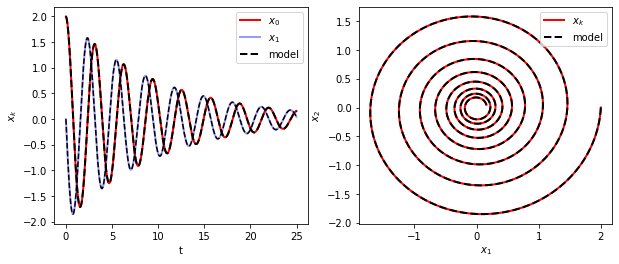

In [26]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

### Cubic 2D ODE

SINDy can also identify a *nonlinear* two-dimensional damped harmonic oscillator. This example involves cubic dynamics. The governing system used to generate training data is as follows. It is identical to the previous example except the linear terms in the right-hand side have been replaced with cubic ones.

$$ \frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix} $$

In [27]:
# Generate the Training Data
def f(x, t):
    return [
        -0.1 * x[0] ** 3 + 2 * x[1] ** 3,
        -2 * x[0] ** 3 - 0.1 * x[1] ** 3,
    ]
dt = 0.01
t_train = np.arange(0, 25, dt)
x0_train = [2, 0]
x_train = odeint(f, x0_train, t_train)

In [28]:
# Fit the model

poly_order = 5
threshold = 0.05

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=poly_order),
)
model.fit(x_train, t=dt)
model.print()

x0' = -0.100 x0^3 + 1.999 x1^3
x1' = -1.999 x0^3 + -0.100 x1^3


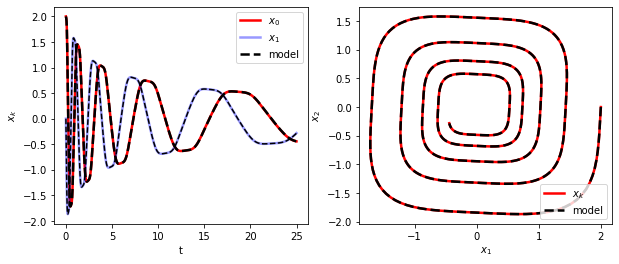

In [29]:
# Simulate and plot the results

x_sim = model.simulate(x0_train, t_train)
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="$x_1$", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="$x_1$", ylabel="$x_2$")
fig.show()

## Lorenz system (nonlinear ODE)

The Lorenz system serves as an example of a nonlinear ODE whose solutions exhibit chaotic dynamics evolving on a strange attractor. The Lorenz system is given by

$$ \begin{aligned} \dot x &= \sigma(y-x)\\ \dot y &= x(\rho - z) - y \\ \dot z &= xy - \beta z, \end{aligned} $$

with $\sigma=10$, $\rho=28$, and $\beta=\tfrac{8}{3}$ for this example. We generate our training data starting from the initial condition $(-8, 8, 27)$. Note that for this example we also collect measurements of derivatives of state variables, $(\dot x, \dot y, \dot z)$.

In [30]:
# Generate training data

def lorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]


dt = 0.001
t_train = np.arange(0, 100, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)


### Measure states $x$ and derivatives $\dot{x}$

In this example, both the states $x$ and derivatives $\dot{x}$ of the Lorenz system are measures, and increasing levels of noise ($\eta$) are added to the derivatives.

In [31]:
# Fit the models and simulate

poly_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)  # Seed for reproducibility

noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

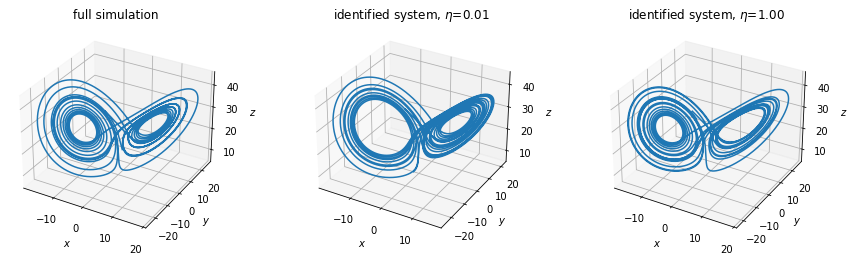

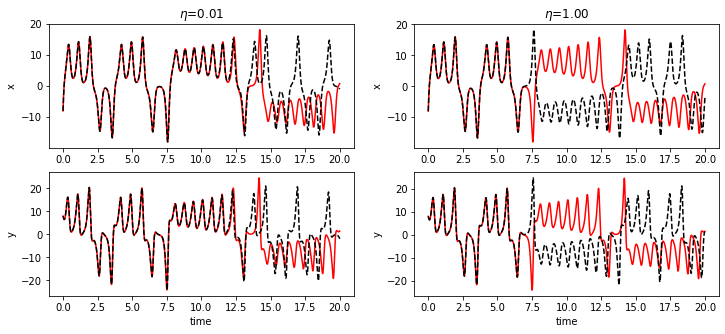

In [32]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()